# Домашка 
---------------------------------------

## Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недостаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети две картинки стиля и она внутри себя (скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

# **Откуда брался код:**
*   Ноутбук с семинара: https://colab.research.google.com/drive/1-X4Q3LkPBLZrQZuLoBj4uA7xP0Hpj8mU
*   Сайт Pytorch: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html




# **Style_Transfer_ТиньгаевМИ_27810390**
# **Комментарий к работе:** Изначально было решено добавить в подсчёт лосс-функции MSE фичи от изображения со вторым стилем. Это дало такой результат:

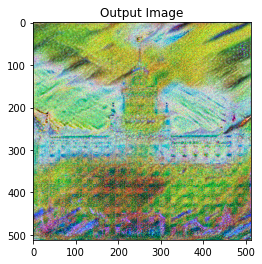

## Затем, добавил большей управляемости стилями. Добавил также вес для второго лосса. Получилось так с весами по 500:

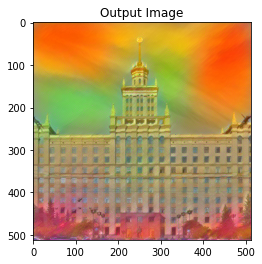

In [29]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy



In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [32]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.CenterCrop(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img_1 = image_loader("/content/drive/MyDrive/Colab Notebooks/Style_transfer/style_1.jpeg")
style_img_2 = image_loader("/content/drive/MyDrive/Colab Notebooks/Style_transfer/style_2.jpeg")
content_img = image_loader("/content/drive/MyDrive/Colab Notebooks/Style_transfer/content.jpeg")

print(content_img.shape, style_img_1.shape, style_img_2.shape)

assert content_img.size() == style_img_1.size() == style_img_2.size(), \
    "we need to import style and content images of the same size"

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


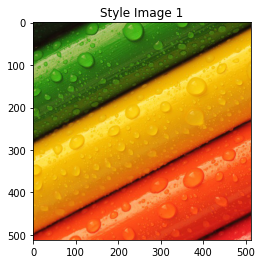

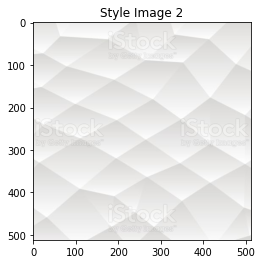

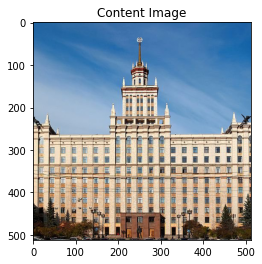

In [33]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img_1, title='Style Image 1')

plt.figure()
imshow(style_img_2, title='Style Image 2')

plt.figure()
imshow(content_img, title='Content Image')

In [34]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [35]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


In [36]:
class StyleLoss(nn.Module):

    # Теперь при инициализации класса передаём 2 фичи - 
    # от 1го и 2го изображений стиля
    def __init__(self, target_feature): #, target_feature_2):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        # self.target_2 = gram_matrix(target_feature_2).detach()

    def forward(self, input):
        G = gram_matrix(input)
        # Добавим в подсчёт лосс-функции MSE также фичи от второго стиля
        self.loss = F.mse_loss(G, self.target) # + self.target_2)
        return input

In [37]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [38]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [39]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img_1, style_img_2, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    content_losses = []
    style_losses_1 = []
    style_losses_2 = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature_1 = model(style_img_1).detach()
            target_feature_2 = model(style_img_2).detach()
            style_loss_1 = StyleLoss(target_feature_1)
            style_loss_2 = StyleLoss(target_feature_2)
            model.add_module("style_loss_1{}".format(i), style_loss_1)
            model.add_module("style_loss_2{}".format(i), style_loss_2)
            style_losses_1.append(style_loss_1)
            style_losses_2.append(style_loss_2)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses_1, style_losses_2, content_losses

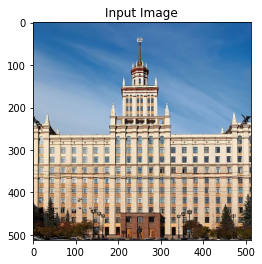

In [40]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [41]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [44]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img_1, style_img_2, input_img, 
                       num_steps=500, style_weight_1=5000, 
                       style_weight_2=5000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses_1, style_losses_2, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img_1, style_img_2, 
        content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score_1 = 0
            style_score_2 = 0
            content_score = 0

            for sl in style_losses_1:
                style_score_1 += sl.loss

            for sl in style_losses_2:
                style_score_2 += sl.loss
            
            for cl in content_losses:
                content_score += cl.loss

            style_score_1 *= style_weight_1
            style_score_2 *= style_weight_2
            content_score *= content_weight

            loss = style_score_1 + style_score_2 + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss 1: {:4f} Style Loss 2: {:4f} Content Loss: {:4f}'.format(
                    style_score_1.item(), style_score_2.item(), content_score.item()))
                print()

            return style_score_1 + style_score_2 + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


run [50]:
Style Loss 1: 15.127430 Style Loss 2: 11.006927 Content Loss: 13.954920

run [100]:
Style Loss 1: 10.787961 Style Loss 2: 12.364518 Content Loss: 14.301749

run [150]:
Style Loss 1: 10.259935 Style Loss 2: 12.492042 Content Loss: 14.019756

run [200]:
Style Loss 1: 10.583396 Style Loss 2: 12.520600 Content Loss: 14.780270

run [250]:
Style Loss 1: 9.963205 Style Loss 2: 12.401978 Content Loss: 14.283996

run [300]:
Style Loss 1: 10.360420 Style Loss 2: 12.038697 Content Loss: 14.632159

run [350]:
Style Loss 1: 88378.773438 Style Loss 2: 89193.820312 Content Loss: 378.020874

run [400]:
Style Loss 1: 17.681417 Style Loss 2: 10.934647 Content Loss: 15.862064

run [450]:
Style Loss 1: 11.110026 Style Loss 2: 12.918543 Content Loss: 14.253959

run [500]:
Style Loss 1: 10.094270 Style Loss 2: 13.385571 Content Loss: 13.956290



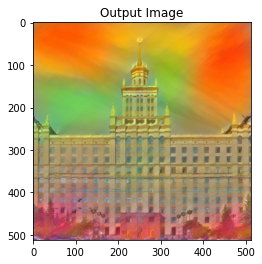

In [45]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img_1, style_img_2, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()